In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import h5py

In [2]:
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self):
        with h5py.File('mydataset.hdf5','r') as f:
            self.outputs = torch.Tensor(np.array(f['delta_map'])).permute([0,3,1,2])
            self.inputs = torch.Tensor(np.array(f['train'])).unsqueeze(1)

    def __len__(self):
        return len(self.outputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx]

In [3]:
train_dataset = CustomImageDataset()

In [4]:
class RotationalEquivariantCNN(nn.Module):
  #@staticmethod
  #def symmetrize(T):
  #  return (T+torch.rot90(T,1,[-2,-1])+torch.rot90(T,2,[-2,-1])+torch.rot90(T,3,[-2,-1]))/4
  def __init__(self):
    super(RotationalEquivariantCNN, self).__init__()
    self.conv1 = nn.Conv2d(2,4,5, padding='same')
    self.conv2 = nn.Conv2d(4,4,5, padding='same')
    self.conv3 = nn.Conv2d(4,1,5, padding='same')

    #self.pool = nn.MaxPool2d(2)

    self.bn1 = nn.BatchNorm2d(4)
    self.bn2 = nn.BatchNorm2d(4)

    #self.t_conv1 = nn.ConvTranspose2d(4, 4, 7, stride=2)
    #self.t_conv2 = nn.ConvTranspose2d(4, 4, 6, stride=2)
    #self.t_conv3 = nn.ConvTranspose2d(4, 1, 6, stride=2)

  def forward(self, img, binary_mask):
    #x = torch.sigmoid((x-0.5).abs())
    #print(x.shape)
    x = torch.cat((img,binary_mask),1)
    x = self.bn1(F.relu(self.conv1(x)))
    x = self.bn2(F.relu(self.conv2(x)))
    x = self.conv3(x)
    #print(x.shape)
    #raise RuntimeError()
    #x = F.relu(self.t_conv1(x))
    #x = F.relu(self.t_conv2(x))
    #x = self.t_conv3(x)
    #x = torch.sigmoid(10*x)
    return x

model = RotationalEquivariantCNN().cuda()

In [5]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 32)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
for t in range(10):
  cumulative_loss = 0
  for _, (inputs, masks) in enumerate(train_dataloader):
    masks = masks.cuda()
    y_pred = model(inputs.cuda(), masks[:,-1,:,:].unsqueeze(1))
    loss = criterion(y_pred, masks[:,0,:,:].unsqueeze(1))
    cumulative_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print(t, cumulative_loss)

0 361.6657724380493
1 350.0731964111328
2 344.2268991470337
3 339.961971282959
4 337.51547145843506
5 335.691707611084
6 334.27656269073486
7 332.97511291503906
8 331.904483795166
9 330.94269704818726


In [8]:
i = train_dataset.inputs.__getitem__(0).squeeze()
m = train_dataset.outputs.__getitem__(0)[-1,:,:].squeeze()
o = model(i.cuda().unsqueeze(0).unsqueeze(0),m.cuda().unsqueeze(0).unsqueeze(0))
o.shape

torch.Size([1, 1, 520, 704])

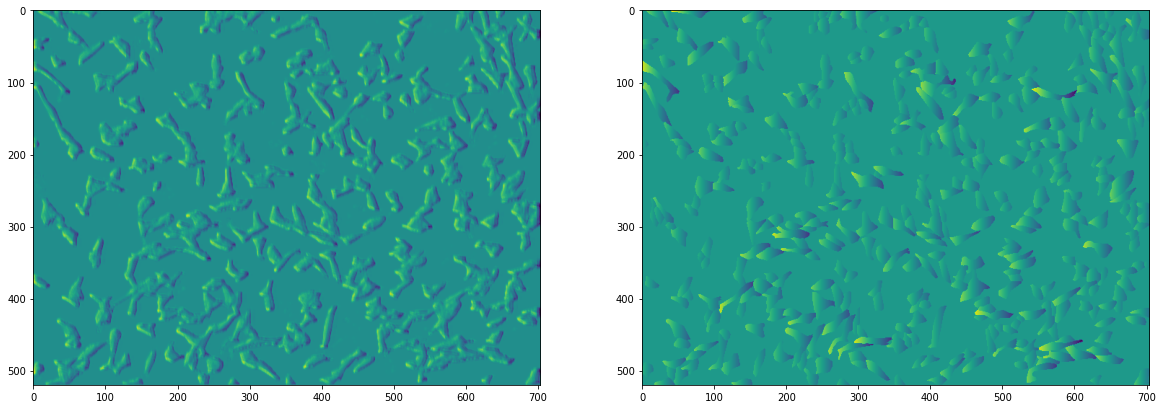

In [12]:
plt.figure(figsize = (20,20))
plt.subplot(1,2,1)
plt.imshow(o.squeeze().detach().cpu())
plt.subplot(1,2,2)
plt.imshow(train_dataset.outputs.__getitem__(0)[0,:,:])
plt.show()

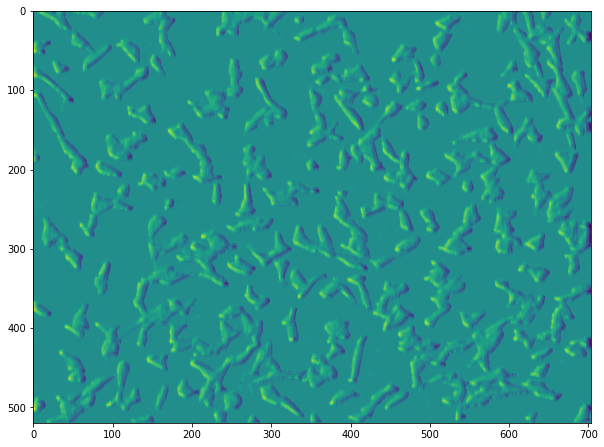

In [9]:
plt.figure(figsize = (10,10))
plt.imshow(o.squeeze().detach().cpu())
plt.show()

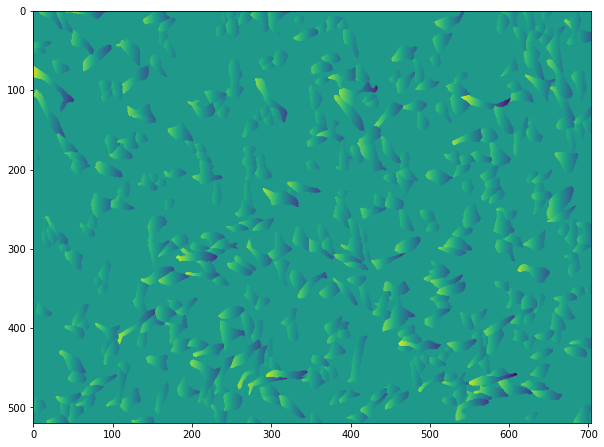

In [ ]:
plt.figure(figsize = (10,10))
plt.imshow(train_dataset.outputs.__getitem__(0)[0,:,:])
plt.show()

In [10]:
pippo = train_dataset.outputs.__getitem__(0)[-1,:,:].squeeze()

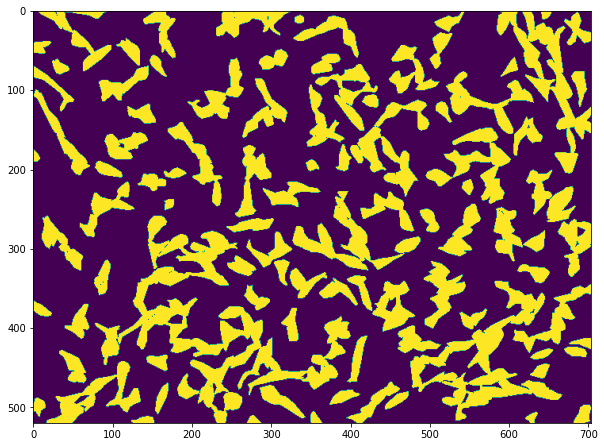

In [24]:
plt.figure(figsize = (10,10))
plt.imshow(pippo)
plt.show()

In [18]:
pippo[16:-16:8,16:-16:8].shape

torch.Size([61, 84])

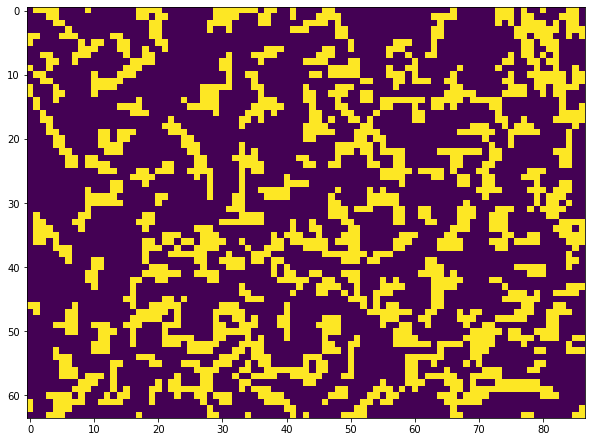

In [50]:
plt.figure(figsize = (10,10))
plt.imshow(pippo[8::8,8::8])
plt.show()

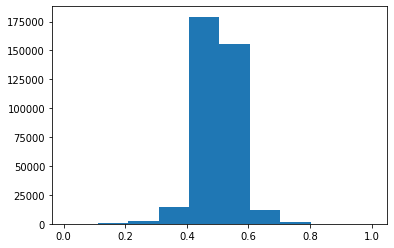

In [27]:
plt.hist(i.flatten().numpy())
plt.show()

KeyboardInterrupt: 

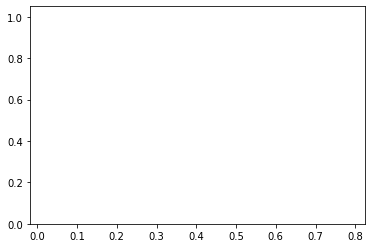

In [20]:
plt.hist(i[::8,::8].flatten())

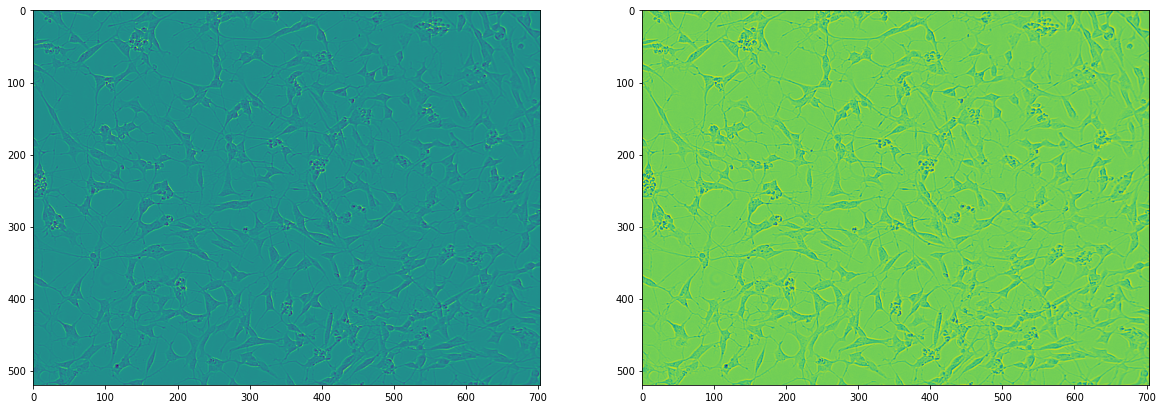

In [18]:
plt.figure(figsize = (20,20))
plt.subplot(1,2,1)
plt.imshow(i)
plt.subplot(1,2,2)
plt.imshow(torch.sigmoid(i*4))
plt.show()

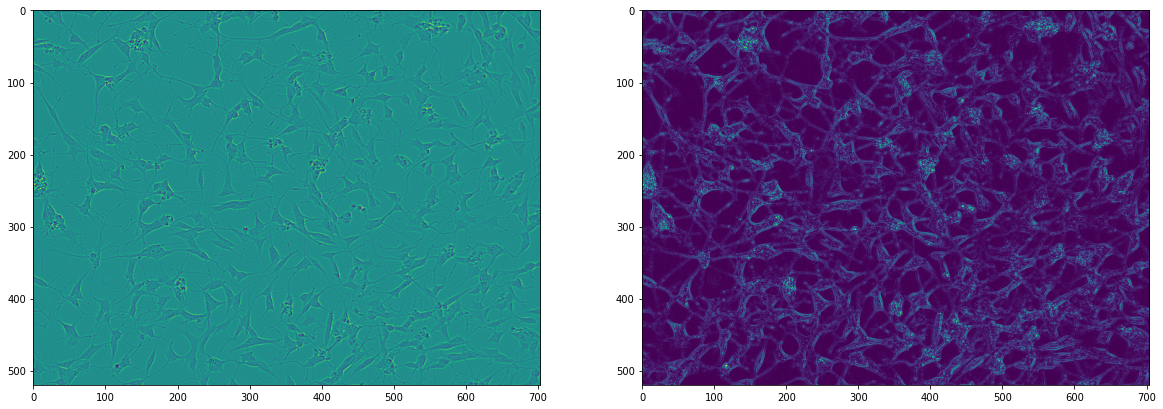

In [38]:
plt.figure(figsize = (20,20))
plt.subplot(1,2,1)
plt.imshow(i)
plt.subplot(1,2,2)
plt.imshow(torch.sigmoid((i-0.5).abs()))
plt.show()

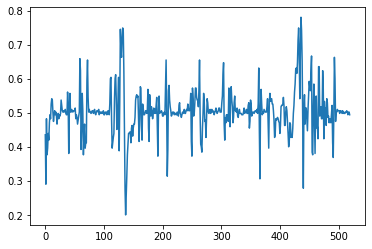

In [28]:
plt.plot(i[:,300])

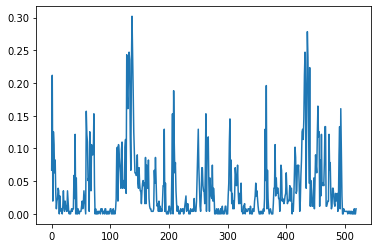

In [33]:
plt.plot((i-i.flatten().median()).abs().reshape(i.shape)[:,300])

In [9]:
import cv2
yolo = (i.numpy()*255).astype(np.uint8)

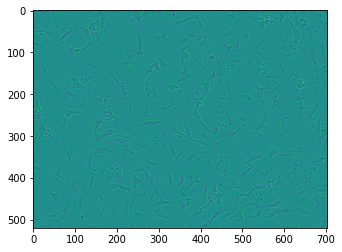

In [13]:
plt.imshow(yolo)

In [24]:
yolo.min()

3

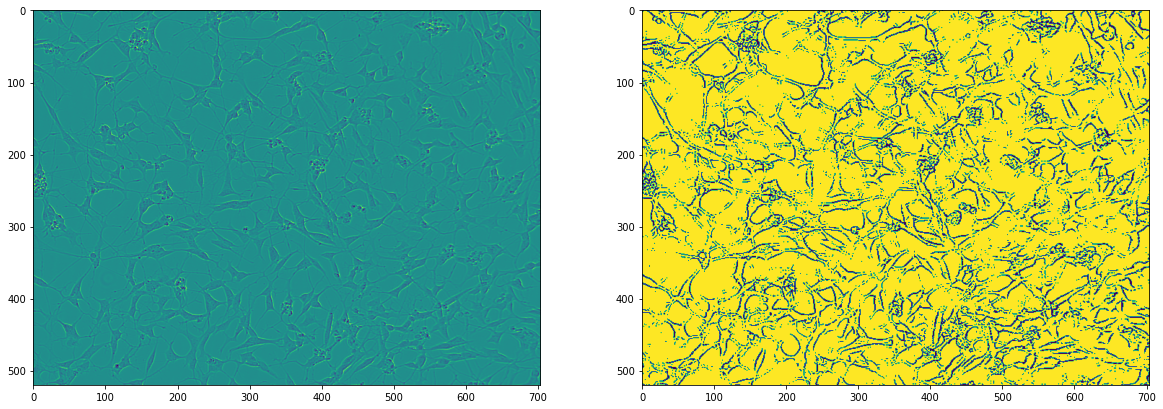

In [35]:
plt.figure(figsize = (20,20))
plt.subplot(1,2,1)
plt.imshow(i)
plt.subplot(1,2,2)
#kernel = np.ones((4,4),np.uint8)
#pluto = cv2.morphologyEx(yolo, cv2.MORPH_OPEN, kernel)
plt.imshow(yolo < 140)
plt.show()

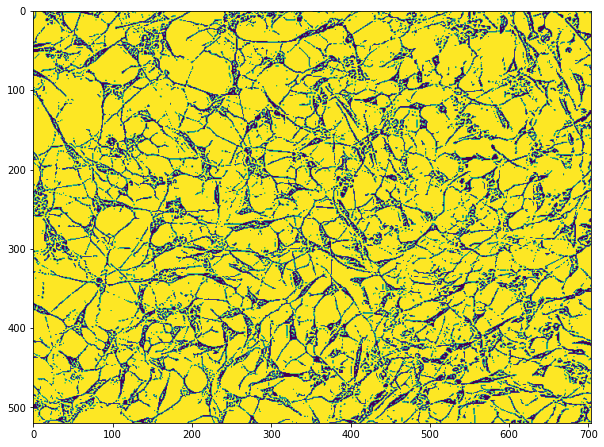

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(cv2.threshold(yolo,120,255,cv2.THRESH_BINARY)[1])
plt.show()

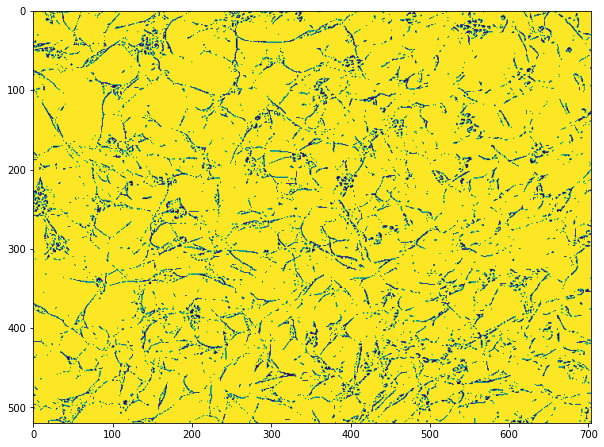

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(cv2.adaptiveThreshold(yolo,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,20))
plt.show()

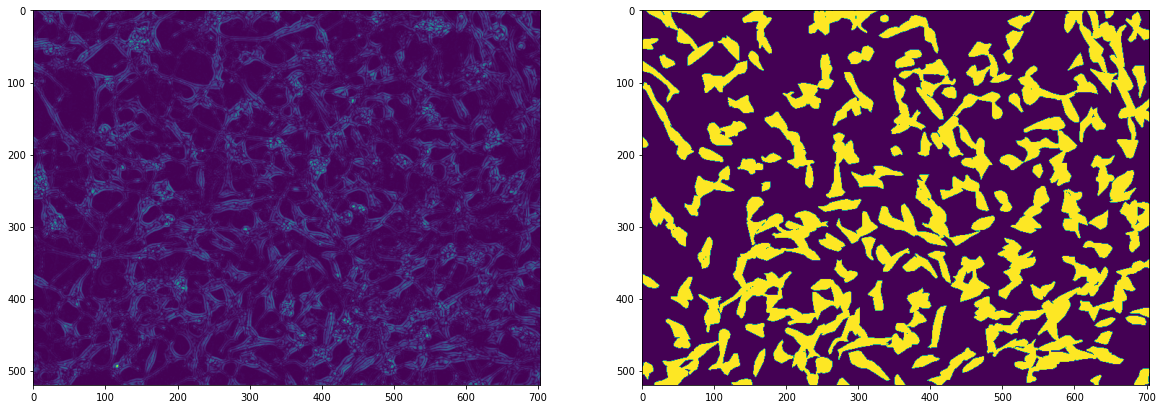

In [17]:
sfocato = cv2.GaussianBlur(yolo, (3,3), 2)
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(np.abs(sfocato-np.mean(sfocato)))
plt.subplot(1,2,2)
plt.imshow(train_dataset.outputs[0,-1,:,:])
plt.show()